In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit import IfElseOp

## First Circuits

It's simple to create a quantum circuit in qiskit. Let's do a very basic example to get started.

### Registers
Circuits in qiskit are actually built up of registers.

Often we'll use quantum registers with qubits and classical registers with bits.

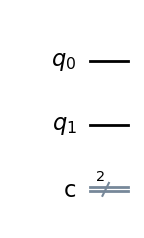

In [2]:
qr = QuantumRegister(2, 'q')
cr = ClassicalRegister(2, 'c')
circ = QuantumCircuit(qr,cr)
circ.draw('mpl')

### Gates

Circuits have the common gates built in as functions. For example, the Hadamard gate is just `h`.

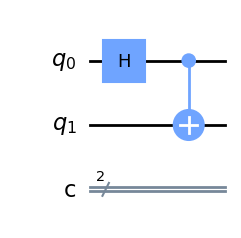

In [3]:
circ.h(0)
circ.cx(0, 1)
circ.draw('mpl')

These will be applied in order from top to bottom.

### Measurements

Finally, we can measure the qubits in our circuit. This will collapse the qubits into a classical bit.

This is why we needed a quantum register and a classical register.

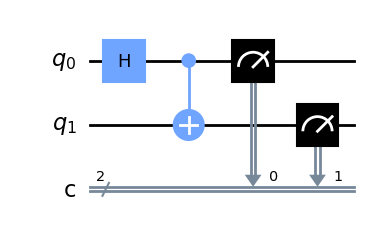

In [4]:
circ.measure(qubit=0, cbit=0)
circ.measure(qubit=1, cbit=1)
circ.draw('mpl')

We can predict what we think this circuit will do by using our Dirac notation, which uses operators $\hat{U}$ and states $\ket{\Psi}$.

At first, the qubit $q_0$ and $q_1$ are in state $\ket{0}$.

$$\ket{\Psi} = \ket{0} \otimes \ket{0}$$

Then, we apply a Hadamard gate to $q_0$ an the identity to $q_1$.

$$\hat{H} \otimes \hat{I} \ket{\Psi}$$

$$= \frac{1}{\sqrt{2}} \left( \ket{0} + \ket{1} \right) \otimes \ket{0}$$

$$= \frac{1}{\sqrt{2}} \left( \ket{00} + \ket{10} \right)$$

Then, we apply a CNOT gate to $q_0$ and $q_1$.

$$\hat{U_{CN}} (\hat{H} \otimes \hat{I}) \ket{\Psi}$$

$$=\hat{U_{CN}} \frac{1}{\sqrt{2}} \left( \ket{00} + \ket{10} \right)$$

$$=\frac{1}{\sqrt{2}} \left( \hat{U_{CN}} \ket{00} + \hat{U_{CN}} \ket{10} \right)$$


$$=\frac{1}{\sqrt{2}} \left( \ket{00} + \ket{11} \right)$$

This type of state is called a Bell State. It is a superposition of two states, $\ket{00}$ and $\ket{11}$.

### Question: What are the probabilities of measuring $\ket{00}$ and $\ket{11}$?

To find a result, we need to use either a quantum computer or a simulator. We'll use the simulator for now.

In [5]:
from qiskit import Aer
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = backend_sim.run(circ, shots=1024)

Now we're ready to see the results.

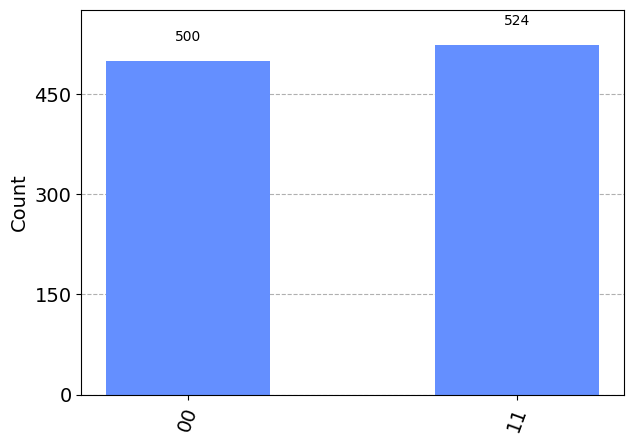

In [6]:
from qiskit.visualization import plot_histogram

# Grab the results from the job.
result_sim = job_sim.result()
counts = result_sim.get_counts(circ)
plot_histogram(counts)

### Question: Did these measurements match our predictions?

Lets create a function to plot the results from a circuit, we'll use this later.

In [7]:
def get_counts(circ):
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = backend_sim.run(circ, shots=1024)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(circ)
    return counts

## Quantum Teleportation

As an example, we'll learn how to make a circuit that performs quantum teleportation.

Imagine we have two people, Alice and Bob. Initially they're in the same room. Alice has a qubit in state $\ket{\Psi}$ and Bob has a qubit in state $\ket{0}$.

To make the teleportation work later, we also give Alice an extra **ancilla** qubit in state $\ket{0}$.

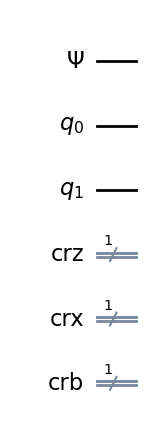

In [8]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
# Include a third register for measuring Bob's result
aqr = QuantumRegister(1, name='\Psi')
qr = QuantumRegister(2, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
crb = ClassicalRegister(1, name="crb")
teleport = QuantumCircuit(aqr, qr, crz, crx, crb)
teleport.draw('mpl')

All qubits start in state $\ket{0}$ so let's change 

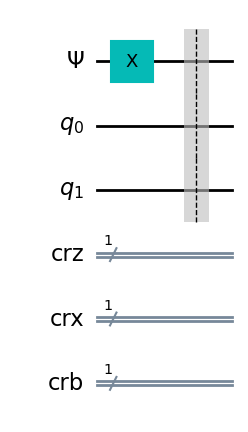

In [9]:
teleport.x(0)
teleport.barrier()
teleport.draw('mpl')

## Step 1: Create an entangled pair

We follow the proceduce from before to create a Bell state.

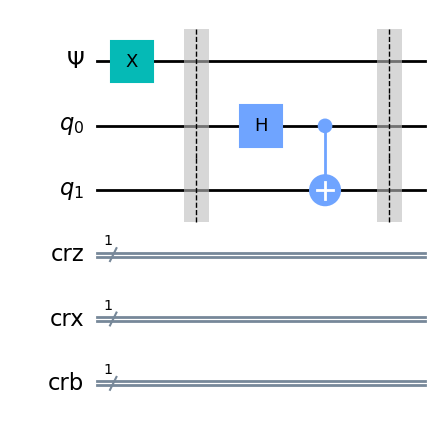

In [10]:
teleport.h(1)
teleport.cx(1, 2)
teleport.barrier()
teleport.draw('mpl')

Qubits $q_1$ and $q_2$ are now entangled.

We give $q_1$ to Alice and $q_2$ to Bob.

Alice takes her qubits to the other side of the planet, or Mars.

## Step 2: Apply a CNOT and Hadamard to Alice's qubits

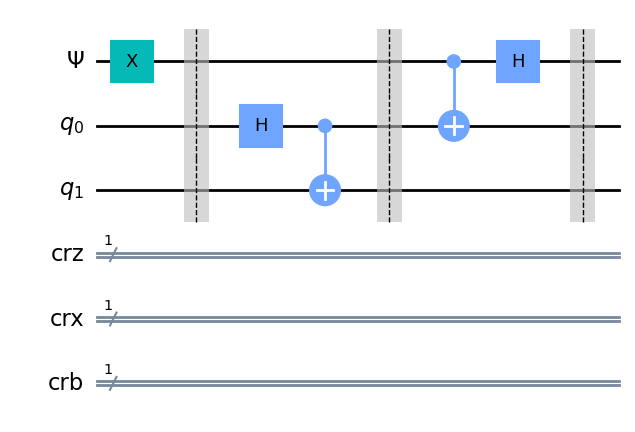

In [11]:
teleport.cx(0, 1)
teleport.h(0)
teleport.barrier()
teleport.draw('mpl')

## Step 3: Measure Alice's qubits

We apply a measurement to both of Alice's qubits $\ket{\psi}$ and $q_1$

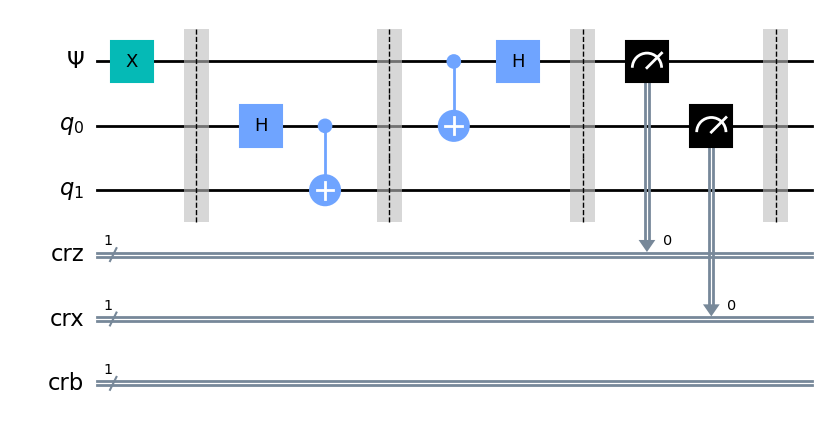

In [12]:
teleport.measure(0, 0)
teleport.measure(1, 1)
teleport.barrier()
teleport.draw('mpl')

We then send the outcomes of these measurements to Bob.

## Step 4: Bob applies gates

Depending on the classical bits sent from Alice, Bob applies the following gates to his qubit:

00: Do nothing

01: Apply $X$

10: Apply $Z$

11: Apply $ZX$

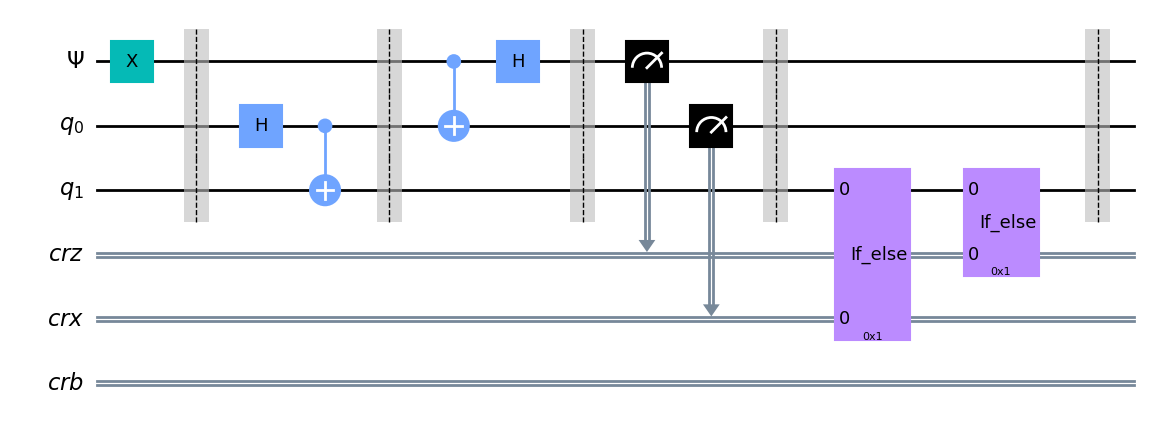

In [13]:
with teleport.if_test((crx, 1)):
    teleport.x(2)
with teleport.if_test((crz, 1)):
    teleport.z(2)
teleport.barrier()
teleport.draw('mpl')

### Step 5: Bob measures his qubit

Bob measures his qubit and gets the state $\ket{\Psi}$.

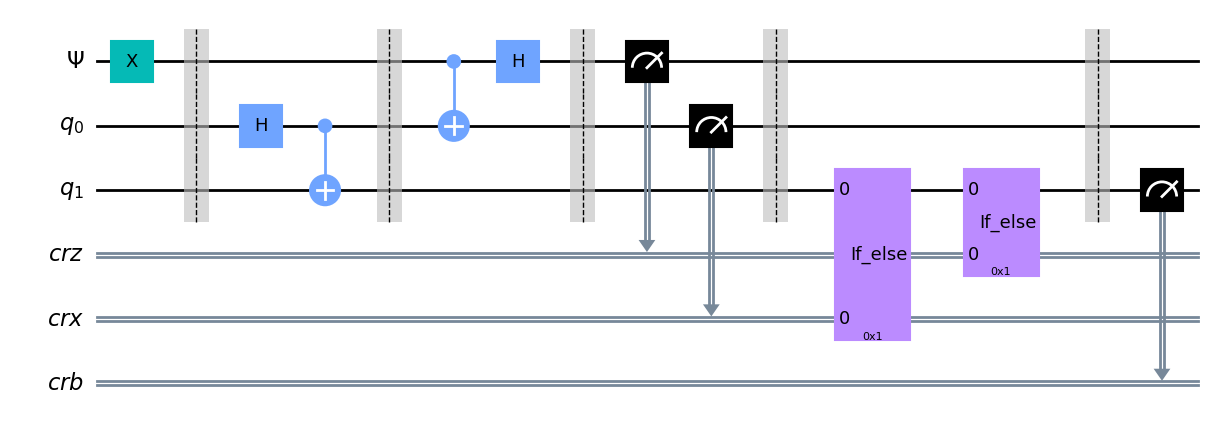

In [14]:
teleport.measure(2, 2)
teleport.draw('mpl')

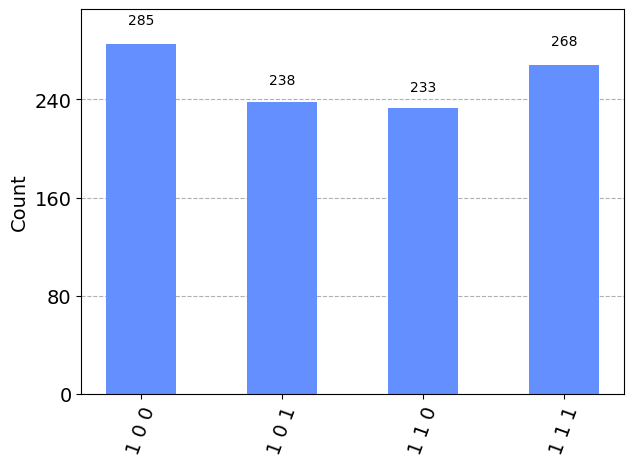

In [15]:
plot_histogram(get_counts(teleport))

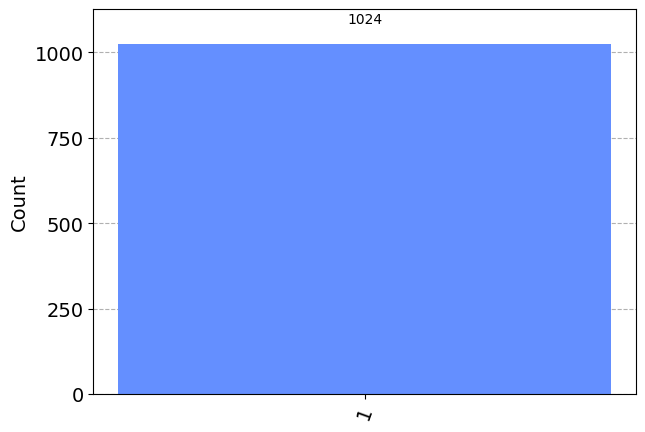

In [16]:
from qiskit.result import marginal_counts
bobs_count = marginal_counts(get_counts(teleport), [2])
plot_histogram(bobs_count)

In [17]:
from ipywidgets import interact, interactive, fixed, interact_manual
from qiskit.visualization import plot_bloch_vector
import ipywidgets as widgets

# Visualising States

def plot_bloch(theta, phi):
    vec = [1, theta, phi]
    fig, ax = plt.figure(figsize=(8,8))
    plot_bloch_vector(ax=ax, bloch=vec, coord_type='spherical')
    fig.show()
